In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

sns.set_style('ticks')

INPUT_DIR = '/analysis/data/atmaCup8/inputs/'
OUTPUT_DIR = '/analysis/data/atmaCup8/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [2]:
train_df.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


In [3]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    idx_tbd = input_df['User_Score'] == 'tbd'
    output_df['User_Score_is_tbd'] = idx_tbd.astype(int)
    
    output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype(float)
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        'Critic_Score',
        'Critic_Count', 
        'User_Score', 
        'User_Count',
        'Year_of_Release',
        'User_Score_is_tbd'
    ]
    return input_df[use_columns].copy()

In [4]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [5]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

### Booleanの特徴量

特定の条件を満たしているかどうか, を表す特徴量です。例えばテキストカラムに特定の文字列が存在しているかどうか、などが該当します。

In [6]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    texts = [
        'japan', 'nintendo'
    ]
    
    for t in texts:
        output_df[f'Developer_has_{t}'] = input_df['Developer'].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

In [7]:
create_boolean_feature(train_df).sum()

Developer_has_japan       23
Developer_has_nintendo    88
dtype: int64

### CountEncoding

In [8]:
['a', 'a', 'b', 'a']

['a', 'a', 'b', 'a']

In [9]:
[3, 3, 1, 3]

[3, 3, 1, 3]

In [10]:
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
        
    def transform(self, input_df):
        raise NotImplementedError()

In [11]:
_df = train_df.groupby('Name')['Platform'].count()
pd.merge(train_df['Name'], _df, on='Name', how='left').values[:, 1]

array([7, 4, 7, ..., 1, 2, 2], dtype=object)

In [12]:
vc = train_df['Name'].value_counts()

In [13]:
train_df['Name'].map(vc).values

array([7, 4, 7, ..., 1, 2, 2])

In [14]:
class CountEncodingBlock(BaseBlock):
    def __init__(self, column, whole_df: pd.DataFrame):
        self.column = column
        self.whole_df = whole_df

    def transform(self, input_df):
        output_df = pd.DataFrame()
        c = self.column
        
        vc = self.whole_df[c].value_counts()
        output_df[c] = input_df[c].map(vc)
        return output_df.add_prefix('CE_')

In [15]:
assert len(train_df) == len(CountEncodingBlock('Name', whole_df=whole_df).fit(train_df))

### OneHotEncoding

In [16]:
['a', 'a', 'b', 'c', 'a']

['a', 'a', 'b', 'c', 'a']

In [17]:
[
    [1, 0],
    [1, 0],
    [0, 1],
    [1, 0]
]

[[1, 0], [1, 0], [0, 1], [1, 0]]

In [18]:
class OneHotBlock(BaseBlock):
    def __init__(self, column: str):
        self.column = column
        self.cats_ = None
        
    def fit(self, input_df, y=None):
        vc = input_df[self.column].dropna().value_counts()
        cats = vc[vc > 40].index
        self.cats_ = cats
        return self.transform(input_df)
    
    def transform(self, input_df):
        x = pd.Categorical(input_df[self.column], categories=self.cats_)
        out_df = pd.get_dummies(x, dummy_na=False)
        out_df.columns = out_df.columns.tolist()
        return out_df.add_prefix(f'OH_{self.column}=')

In [19]:
OneHotBlock('Platform').fit(train_df).sum(axis=0)

OH_Platform=DS      1106
OH_Platform=PS2     1104
OH_Platform=Wii      645
OH_Platform=PS3      643
OH_Platform=PSP      642
OH_Platform=X360     588
OH_Platform=PS       512
OH_Platform=GBA      445
OH_Platform=PC       439
OH_Platform=XB       371
OH_Platform=3DS      270
OH_Platform=GC       240
OH_Platform=PSV      240
OH_Platform=PS4      206
OH_Platform=SNES     130
OH_Platform=SAT      129
OH_Platform=N64      125
OH_Platform=XOne     121
OH_Platform=2600      88
OH_Platform=WiiU      87
OH_Platform=GB        78
OH_Platform=NES       66
OH_Platform=DC        41
dtype: int64

### 凝った特徴量

In [20]:
!pip install textdistance

You should consider upgrading via the '/home/penguin/.conda/bin/python -m pip install --upgrade pip' command.


In [21]:
from textdistance import jaro

In [22]:
jaro('foo', 'fo9')

0.7777777777777777

In [23]:
query = train_df['Name'].values[100]

In [24]:
query

'Frogs And Flies'

In [25]:
results = train_df['Name'].map(lambda x: jaro(query, x))

In [26]:
train_df['Name'][results > .8]

100    Frogs And Flies
Name: Name, dtype: object

In [27]:
!pip install texthero

You should consider upgrading via the '/home/penguin/.conda/bin/python -m pip install --upgrade pip' command.


In [28]:
import texthero as hero
from texthero import preprocessing

In [29]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords # stopword
                  ]

In [30]:
names = hero.clean(whole_df['Name'], custom_pipeline)

In [31]:
words = [w for row in names.str.split(' ') for w in row if len(w) > 0]

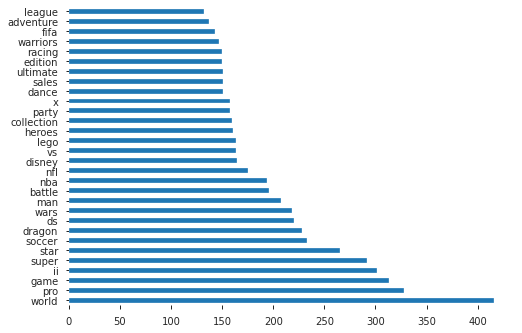

In [32]:
pd.Series(words).value_counts().head(30).plot(kind='barh')

単語1語で見るとどうしてもゲームタイトルというよりジャンルの名前になってくるので, ツナガリを1つの単語とみなして count してみます。`nltk` の ngrams を使うのが便利だと思います。

In [33]:
import texthero as hero
from texthero import preprocessing

In [34]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]

In [35]:
names = hero.clean(whole_df['Name'], custom_pipeline)

In [36]:
from nltk.util import ngrams

def line_ngram(line, n=2):
    words = [w for w in line.split(' ') if len(w) != 0] # 空文字は取り除く
    return list(ngrams(words, n))

In [37]:
name_grams = names.map(line_ngram)

In [38]:
train_df['Name'][0]

'LEGO Batman: The Videogame'

In [39]:
name_grams[0]

[('lego', 'batman'), ('batman', 'videogame')]

In [40]:
grams = [x for row in name_grams for x in row if len(x) > 0]

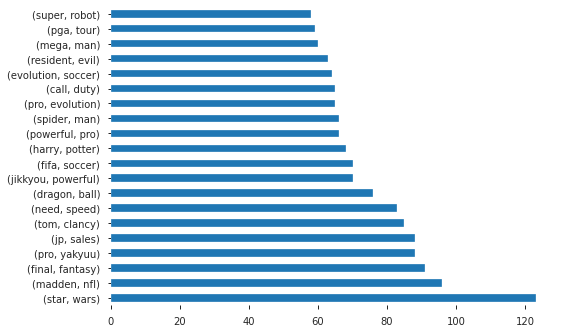

In [41]:
pd.Series(grams).value_counts().head(20).plot(kind='barh')

In [42]:
top_grams = pd.Series(grams).value_counts().head(20).index

In [43]:
w = top_grams[0]
name_grams.map(lambda x: w in x).sum()

123

### n-gram の特徴量への使い方

上位に属している組み合わせが存在するかどうかを 0-1 のフラグとして持つ方法があるでしょう。

In [44]:
def clearn_by_hero(x):
    custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                   , preprocessing.remove_stopwords
                  ]
    return hero.clean(x, custom_pipeline)

def create_n_gram(x, n=3):
    x = clearn_by_hero(x)
    x = pd.Series(x).map(lambda r: line_ngram(r, n=n))
    return x

class NameNGramBlock(BaseBlock):
    def __init__(self, whole_df, n=3):
        self.whole_df = whole_df
        self.n = n
    
    def fit(self, input_df, y=None):
        name_grams = create_n_gram(self.whole_df['Name'], n=self.n)
        grams = [x for row in name_grams for x in row if len(x) > 0]
        top_grams = pd.Series(grams).value_counts().head(20).index
        
        self.top_grams_ = top_grams
        return self.transform(input_df)
    
    def transform(self, input_df):
        name_grams = create_n_gram(input_df['Name'], n=self.n)
        output_df = pd.DataFrame()
        
        for top in self.top_grams_:
            s_top = '-'.join(top)
            output_df[f'{s_top}'] = name_grams.map(lambda x: top in x).map(int)

        return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [45]:
block = NameNGramBlock(train_df, n=3)
block.fit(train_df).head()

,Name_has_major-league-baseball_n=3,Name_has_grand-theft-auto_n=3,Name_has_wwe-smackdown-vs_n=3,Name_has_super-robot-taisen_n=3,Name_has_smackdown-vs-raw_n=3,Name_has_shin-megami-tensei_n=3,Name_has_dragon-ball-z_n=3,Name_has_lego-star-wars_n=3,Name_has_katekyoo-hitman-reborn_n=3,Name_has_star-wars-force_n=3,Name_has_marvel-super-heroes_n=3,Name_has_romance-three-kingdoms_n=3,Name_has_hisshou-pachinko-pachi_n=3,Name_has_slot-kouryaku-series_n=3,Name_has_lego-harry-potter_n=3,Name_has_mx-vs-atv_n=3,Name_has_pachinko-pachi-slot_n=3,Name_has_pachi-slot-kouryaku_n=3,Name_has_rock-band-track_n=3,Name_has_band-track-pack_n=3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [46]:
block.transform(test_df).sum()

Name_has_major-league-baseball_n=3     14
Name_has_grand-theft-auto_n=3           0
Name_has_wwe-smackdown-vs_n=3           1
Name_has_super-robot-taisen_n=3        16
Name_has_smackdown-vs-raw_n=3           1
Name_has_shin-megami-tensei_n=3         1
Name_has_dragon-ball-z_n=3             24
Name_has_lego-star-wars_n=3             6
Name_has_katekyoo-hitman-reborn_n=3     0
Name_has_star-wars-force_n=3            0
Name_has_marvel-super-heroes_n=3        2
Name_has_romance-three-kingdoms_n=3     0
Name_has_hisshou-pachinko-pachi_n=3     0
Name_has_slot-kouryaku-series_n=3       0
Name_has_lego-harry-potter_n=3          0
Name_has_mx-vs-atv_n=3                  4
Name_has_pachinko-pachi-slot_n=3        0
Name_has_pachi-slot-kouryaku_n=3        0
Name_has_rock-band-track_n=3            0
Name_has_band-track-pack_n=3            0
dtype: int64

### Trainにしかない情報を使う

1. そのカラムを予測する (target 以外のカラムを予測する)
2. 他のカラムに集約する

In [47]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [48]:
sales_columns

['EU_Sales', 'Global_Sales', 'JP_Sales', 'NA_Sales', 'Other_Sales']

In [49]:
key = 'Genre'

input_df = train_df
input_df[sales_columns].groupby(input_df[key]).sum()

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,30483,106343,10165,54010,11610
Adventure,4522,16634,3753,7229,1131
Fighting,5807,27258,5808,13313,2307
Misc,13411,48441,7803,22588,4601
Platform,16573,71149,12114,38119,4320
Puzzle,3871,19153,4497,9849,921
Racing,13039,44301,5026,21745,4465
Role-Playing,13536,72067,29886,24282,4348
Shooter,10890,43028,1964,26631,3506


key ごとに正規化するのも好きです. この場合だとジャンルごとのポートフォリオみたいになりますね。

In [50]:
key = 'Genre'

input_df = train_df

_df = input_df[sales_columns].groupby(input_df[key]).sum()
_df = (_df.T / _df.sum(axis=1)).T
_df

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,0.143375,0.500176,0.047810,0.254032,0.054607
Adventure,0.135922,0.499985,0.112808,0.217289,0.033996
Fighting,0.106564,0.500211,0.106582,0.244307,0.042336
Misc,0.138480,0.500196,0.080573,0.233241,0.047509
Platform,0.116486,0.500081,0.085145,0.267925,0.030364
Puzzle,0.101094,0.500196,0.117443,0.257214,0.024053
Racing,0.147207,0.500147,0.056742,0.245495,0.050409
Role-Playing,0.093922,0.500052,0.207370,0.168486,0.030170
Shooter,0.126600,0.500215,0.022832,0.309594,0.040758


### Note

* 動画中説明するのを忘れていましたが、 sales の情報は間接的に global sales の情報を表していますので若干リスクがあります(リークになる可能性があります)
    * リークを防ぐ方法の一つとして Out-of-Fold を作る容量で集計する方法があります。(target encoding と同じ要領です)

In [51]:
class SalesPortfolioBlock(BaseBlock):
    """売上ポートフォリオ"""
    
    def __init__(self, key: str):
        self.key = key    
        self.meta_df = None
    
    def fit(self, input_df):
        _df = input_df[sales_columns].groupby(input_df[self.key]).sum()
        _df = (_df.T / _df.sum(axis=1)).T
        self.meta_df = _df
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
        out_df = out_df.add_prefix(f'SP@{self.key}_')
        return out_df

In [52]:
class WrapperBlock(BaseBlock):
    def __init__(self, function):
        self.function = function
        
    def transform(self, input_df):
        return self.function(input_df)

In [53]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [54]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    WrapperBlock(create_boolean_feature),
    NameNGramBlock(whole_df, n=3),
    *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Rating']],
    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Year_of_Release']],
    *[SalesPortfolioBlock(c) for c in ['Genre']]
]

In [55]:
process_blocks

In [56]:
from tqdm import tqdm


def get_function(block, is_train):
    s = mapping = {
        True: 'fit',
        False: 'transform'
    }.get(is_train)
    return getattr(block, s)
    

def to_feature(input_df, 
               blocks,
               is_train=False):
    out_df = pd.DataFrame()
    
    for block in tqdm(blocks, total=len(blocks)):
        func = get_function(block, is_train)
        
        with timer(prefix='create ' + str(block) + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [57]:
train_feat_df = to_feature(train_df, process_blocks, is_train=True)
test_feat_df = to_feature(test_df, process_blocks)

  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.WrapperBlock object at 0x7f3df81b22d0> 0.005[s]
create <__main__.WrapperBlock object at 0x7f3df81b2b10> 0.015[s]


  0%|          | 0/11 [00:00<?, ?it/s]

create <__main__.NameNGramBlock object at 0x7f3df81b2ed0> 0.591[s]
create <__main__.OneHotBlock object at 0x7f3df81b2550> 0.004[s]
create <__main__.OneHotBlock object at 0x7f3df81b2950> 0.003[s]
create <__main__.OneHotBlock object at 0x7f3df8222350> 0.004[s]
create <__main__.OneHotBlock object at 0x7f3df8222dd0> 0.003[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222690> 0.007[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222710> 0.005[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222b90> 0.003[s]
create <__main__.SalesPortfolioBlock object at 0x7f3df8222b10> 0.009[s]
create <__main__.WrapperBlock object at 0x7f3df81b22d0> 0.005[s]
create <__main__.WrapperBlock object at 0x7f3df81b2b10> 0.014[s]


100%|██████████| 11/11 [00:00<00:00, 34.50it/s]

create <__main__.NameNGramBlock object at 0x7f3df81b2ed0> 0.259[s]
create <__main__.OneHotBlock object at 0x7f3df81b2550> 0.002[s]
create <__main__.OneHotBlock object at 0x7f3df81b2950> 0.002[s]
create <__main__.OneHotBlock object at 0x7f3df8222350> 0.002[s]
create <__main__.OneHotBlock object at 0x7f3df8222dd0> 0.001[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222690> 0.008[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222710> 0.004[s]
create <__main__.CountEncodingBlock object at 0x7f3df8222b90> 0.003[s]
create <__main__.SalesPortfolioBlock object at 0x7f3df8222b10> 0.003[s]


In [58]:
test_feat_df.head().T

,0,1,2,3,4
Critic_Score,84.000000,91.000000,87.000000,70.000000,71.000000
Critic_Count,23.000000,17.000000,28.000000,54.000000,41.000000
User_Score,8.000000,9.000000,8.500000,6.900000,6.900000
User_Count,19.000000,132.000000,39.000000,180.000000,143.000000
Year_of_Release,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
SP@Genre_EU_Sales,0.143375,0.143375,0.143375,0.143375,0.143375
SP@Genre_Global_Sales,0.500176,0.500176,0.500176,0.500176,0.500176
SP@Genre_JP_Sales,0.047810,0.047810,0.047810,0.047810,0.047810
SP@Genre_NA_Sales,0.254032,0.254032,0.254032,0.254032,0.254032


In [59]:
assert len(test_feat_df) == len(test_df)

### LightGBM による CrossValidation を用いた学習

In [60]:
import lightgbm as lgbm
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error
    
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、そこまでセンシティブではありません。しかし、内部的にどういう意味を持つのかを知っておくと、問題ごとにどういうパラメータが良いかの感覚がわかったり、チューニングする際にも有効なパラメータに絞ってチューニングできますので、重要な変数に関してはその意味についてざっと目を通しておくことをおすすめします。

以下参考文献です。

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。日本語です。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド。英語です。

In [61]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Global_Sales'].values
y = np.log1p(y) # log + plus1 変換する

In [62]:
from sklearn.model_selection import KFold, GroupKFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [63]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.939129
[100]	valid_0's rmse: 0.908638
[150]	valid_0's rmse: 0.897666
[200]	valid_0's rmse: 0.893584
[250]	valid_0's rmse: 0.890756
[300]	valid_0's rmse: 0.891143
Early stopping, best iteration is:
[276]	valid_0's rmse: 0.890017
fit fold=1 0.289[s]
Fold 0 RMSLE: 0.8900
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.947421
[100]	valid_0's rmse: 0.91343
[150]	valid_0's rmse: 0.899945
[200]	valid_0's rmse: 0.892313
[250]	valid_0's rmse: 0.886754
[300]	valid_0's rmse: 0.885993
[350]	valid_0's rmse: 0.885327
Early stopping, best iteration is:
[339]	valid_0's rmse: 0.884848
fit fold=2 0.404[s]
Fold 1 RMSLE: 0.8848
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.910367
[100]	valid_0's rmse: 0.881886
[150]	valid_0's rmse: 0.870902
[200]	valid_0's rmse: 0.867478
[250]	valid_0's rmse: 0.866217
[300]	valid_0's rmse: 0.864301
[350]	valid_0's rm

In [64]:
def split_by_groups(groups):
    kfold = KFold(n_splits=10, random_state=71, shuffle=True)
    groups = pd.Series(groups)
    
    unique_groups = groups.unique()
    splits = []
    
    def _filter_ids(idx):
        values = unique_groups[idx]
        idx = groups.isin(values)
        return groups[idx].index.values
    
    for idx_tr, idx_val in kfold.split(unique_groups):
        splits.append([
            _filter_ids(idx_tr), _filter_ids(idx_val)
        ])
        
    return splits

In [65]:
# cv = split_by_groups(train_df['Publisher'])
# oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

In [66]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

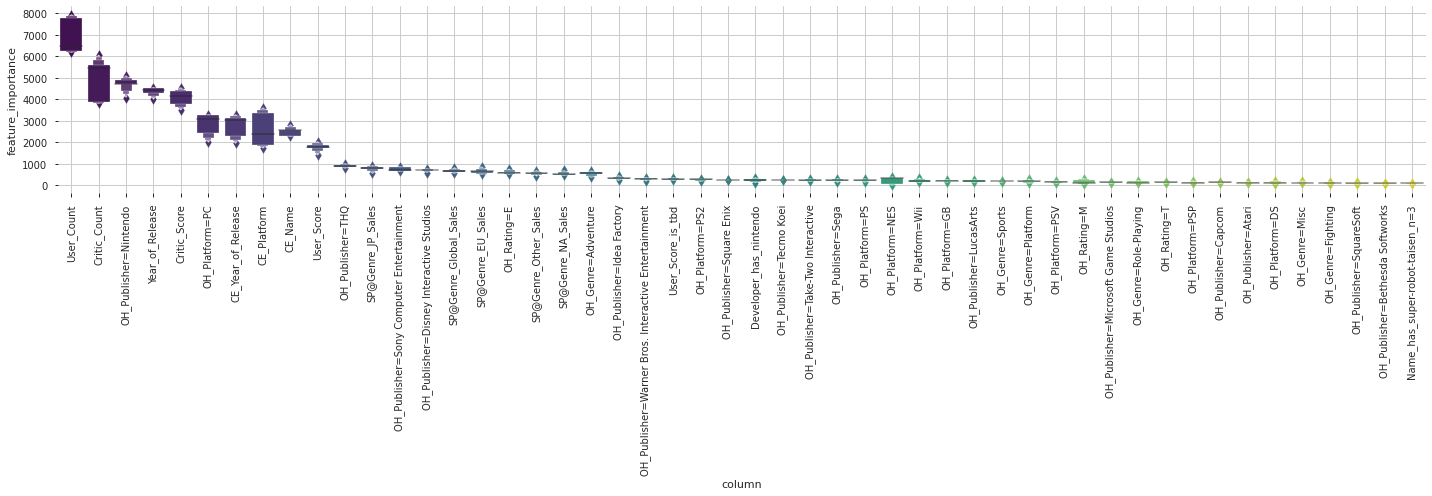

In [67]:
fig, ax = visualize_importance(models, train_feat_df)

In [68]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'simple_submission.csv'), index=False)

Submission する前には予測値がまともかどうかちゃんと見ておきます。(貴重なsubmissionを無駄にしないため)

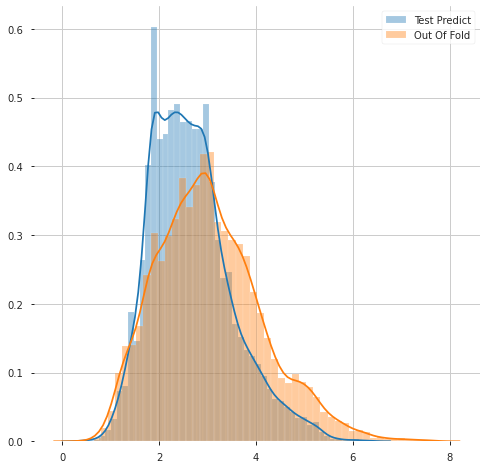

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(oof, label='Out Of Fold')
ax.legend()
ax.grid()